In [1]:
# Step 0: Install required packages (run once)
# In Jupyter/Colab you can run this cell. In terminal, run the pip commands directly.
!pip install yfinance arch statsmodels matplotlib pandas numpy --quiet
print("Install complete (if not already installed). Restart kernel if needed.")

Install complete (if not already installed). Restart kernel if needed.


In [2]:
# Step 1: Imports & simple config
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from pandas.tseries.offsets import BDay

# Config: change ticker/date if you want
TICKER = "TSLA"
START = "2018-01-01"
END   = "2023-12-31"
HORIZON = 5   # how many days of volatility forecast to print

print("Config:", TICKER, START, END, "HORIZON:", HORIZON)

Config: TSLA 2018-01-01 2023-12-31 HORIZON: 5


Using price column: Close
Rows: 1509  Date range: 2018-01-02 to 2023-12-29


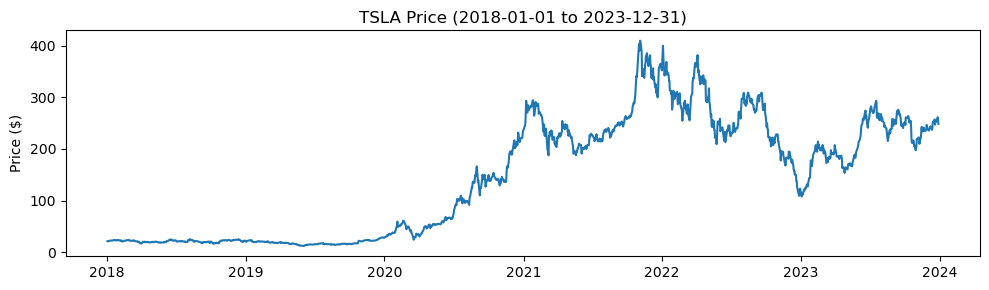

In [3]:
# Step 2: Download prices
print("Downloading data...")
data = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)

if data.empty:
    raise SystemExit("No data fetched. Check ticker/dates/internet.")

# Use adjusted close if present
price_col = "Adj Close" if "Adj Close" in data.columns else "Close"
prices = data[price_col].copy()

print(f"Using price column: {price_col}")
print(f"Rows: {len(prices)}  Date range: {prices.index.min().date()} to {prices.index.max().date()}")

# Quick price plot
plt.figure(figsize=(10,3))
plt.plot(prices)
plt.title(f"{TICKER} Price ({START} to {END})")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

Sample returns (first 5):
Ticker          TSLA
Date                
2018-01-03 -0.010286
2018-01-04 -0.008325
2018-01-05  0.006210
2018-01-08  0.060755
2018-01-09 -0.008118


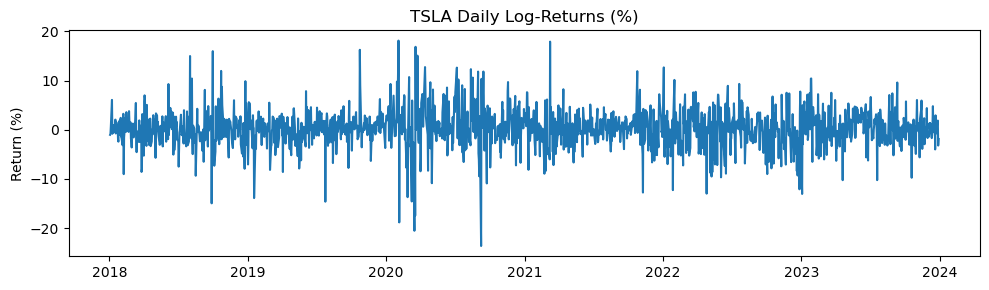

In [4]:
# Step 3: Compute log-returns
returns = np.log(prices / prices.shift(1)).dropna()
print("Sample returns (first 5):")
print(returns.head())

# Plot returns (%)
plt.figure(figsize=(10,3))
plt.plot(returns*100)
plt.title(f"{TICKER} Daily Log-Returns (%)")
plt.ylabel("Return (%)")
plt.tight_layout()
plt.show()

In [5]:
# Step 4: Fit ARIMA(1,0,1)
print("Fitting ARIMA(1,0,1) ...")
arma_model = ARIMA(returns, order=(1,0,1))
arma_res = arma_model.fit()
print("\nARIMA summary (first lines):")
print(arma_res.summary().tables[0])
print(arma_res.summary().tables[1])

Fitting ARIMA(1,0,1) ...


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA summary (first lines):
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 1508
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2710.574
Date:                Sat, 04 Oct 2025   AIC                          -5413.147
Time:                        00:47:20   BIC                          -5391.873
Sample:                             0   HQIC                         -5405.224
                               - 1508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.580      0.114      -0.000       0.004
ar.L1          0.1601      1.546      0.104      0.918      -2.871       3.191
ma.L1         -0.1726 

Residuals mean (should be ~0): 4.908355687423713e-06


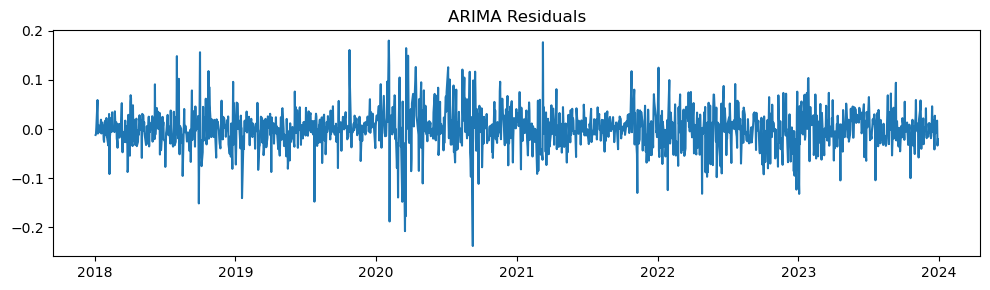

Engle ARCH test (nlags=10): LM stat = 89.7297, p-value = 0.0000
=> ARCH effect significant (use GARCH).


In [6]:
# Step 5: Residuals and ARCH test
resid = arma_res.resid
print("Residuals mean (should be ~0):", resid.mean())

# Plot residuals
plt.figure(figsize=(10,3))
plt.plot(resid)
plt.title("ARIMA Residuals")
plt.tight_layout()
plt.show()

# Engle ARCH test (nlags=10)
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid, nlags=10)
print(f"Engle ARCH test (nlags=10): LM stat = {lm_stat:.4f}, p-value = {lm_pvalue:.4f}")
if lm_pvalue < 0.05:
    print("=> ARCH effect significant (use GARCH).")
else:
    print("=> ARCH effect not strongly indicated, but you can still try GARCH.")

In [7]:
# Step 6: Fit GARCH(1,1)
print("Fitting GARCH(1,1) ...")
garch = arch_model(resid, vol="GARCH", p=1, q=1, mean="Zero", dist="normal")
garch_res = garch.fit(disp="off")
print("\nGARCH(1,1) summary:")
print(garch_res.summary())

Fitting GARCH(1,1) ...

GARCH(1,1) summary:
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2784.15
Distribution:                  Normal   AIC:                          -5562.30
Method:            Maximum Likelihood   BIC:                          -5546.34
                                        No. Observations:                 1508
Date:                Sat, Oct 04 2025   Df Residuals:                     1508
Time:                        00:48:10   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2

C:\Users\Hania\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [8]:
# Step 7: Forecast
print("Forecasting...")


Forecasting...


In [9]:
# ARIMA 1-step forecast (log-return)
arma_fc = arma_res.get_forecast(steps=1)
pred_logret = float(arma_fc.predicted_mean.iloc[0])
pred_pct = pred_logret * 100
print(f"\nARIMA forecast - next-day log-return = {pred_logret:.6e} ({pred_pct:.4f}%)")



ARIMA forecast - next-day log-return = 1.941789e-03 (0.1942%)


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
# GARCH forecast (variance) for HORIZON days
garch_fc = garch_res.forecast(horizon=HORIZON)
var_row = garch_fc.variance.iloc[-1]   # get the forecast row
var_array = var_row.values
std_array = np.sqrt(var_array)
print(f"\nGARCH forecast - next {HORIZON} days (variance & std dev):")
for i, (v, s) in enumerate(zip(var_array, std_array), start=1):
    print(f" Day {i}: Variance = {v:.8e}, StdDev ≈ {s*100:.4f}%")


GARCH forecast - next 5 days (variance & std dev):
 Day 1: Variance = 8.67125472e-04, StdDev ≈ 2.9447%
 Day 2: Variance = 8.81941730e-04, StdDev ≈ 2.9698%
 Day 3: Variance = 8.96461662e-04, StdDev ≈ 2.9941%
 Day 4: Variance = 9.10691196e-04, StdDev ≈ 3.0178%
 Day 5: Variance = 9.24636140e-04, StdDev ≈ 3.0408%


In [14]:
# Step 8: Convert log-return to price with Confidence Interval

# Ensure prices is Series
prices = prices.squeeze()

# Safely extract last price as float
val = prices.iloc[-1]
try:
    last_price = float(val)
except Exception:
    if isinstance(val, pd.Series):
        last_price = float(val.iloc[0])
    else:
        last_price = float(np.asarray(val).flatten()[0])

# Predicted log-return (already from ARIMA step)
pred_price = last_price * np.exp(pred_logret)

# Get next-day volatility forecast (from GARCH)
garch_fc = garch_res.forecast(horizon=1)
next_var = garch_fc.variance.iloc[-1, 0]
next_vol = np.sqrt(next_var)   # standard deviation

# Confidence interval (approx. ±1 std dev in log-returns)
low_price = last_price * np.exp(pred_logret - next_vol)
high_price = last_price * np.exp(pred_logret + next_vol)

# Print results
print(f"\n Last observed price ({prices.index[-1].date()}): ${last_price:.2f}")
print(f" Point forecast next trading-day: ${pred_price:.2f}")
print(f" 95% Approx. Range: ${low_price:.2f}  →  ${high_price:.2f}")
print(f"(Range is based on ±1 std dev from GARCH volatility)")


 Last observed price (2023-12-29): $248.48
 Point forecast next trading-day: $248.96
 95% Approx. Range: $241.74  →  $256.40
(Range is based on ±1 std dev from GARCH volatility)


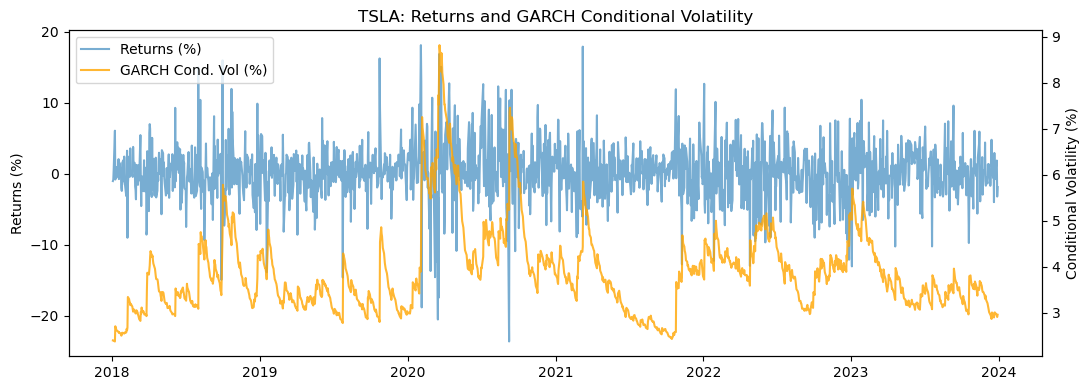

In [13]:
# Step 9: Plot returns and conditional volatility
plt.figure(figsize=(11,4))
ax = plt.gca()
ax.plot(returns.index, returns*100, label="Returns (%)", alpha=0.6)
ax.set_ylabel("Returns (%)")
ax.set_title(f"{TICKER}: Returns and GARCH Conditional Volatility")

ax2 = ax.twinx()
ax2.plot(garch_res.conditional_volatility.index, garch_res.conditional_volatility*100,
         color="orange", label="GARCH Cond. Vol (%)", alpha=0.8)
ax2.set_ylabel("Conditional Volatility (%)")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")
plt.tight_layout()
plt.show()

In [17]:
# Optional diagnostics examples
from statsmodels.stats.diagnostic import acorr_ljungbox
print("\nLjung-Box on residuals (lag 10):")
print(acorr_ljungbox(resid, lags=[10], return_df=True))

print("\nLjung-Box on squared residuals (lag 10):")
print(acorr_ljungbox(resid**2, lags=[10], return_df=True))


Ljung-Box on residuals (lag 10):
      lb_stat  lb_pvalue
10  13.414846   0.201393

Ljung-Box on squared residuals (lag 10):
       lb_stat     lb_pvalue
10  151.914581  1.504538e-27
